# Modeling Extremes - Numpyro Pt 3 - VI

In [1]:
import pandas as pd
from scipy.stats import genextreme
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import numpyro
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import jax
import jax.random as jrandom
import jax.numpy as jnp
from jaxtyping import Array, Float
from tensorflow_probability.substrates.jax import distributions as tfd
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

In [2]:
data_url = "https://raw.githubusercontent.com/georgebv/pyextremes-notebooks/master/data/battery_wl.csv"

data = pd.read_csv(data_url, index_col=0, parse_dates=True).squeeze()
data.describe()

count    809903.000000
mean         -0.119026
std           0.533992
min          -2.122000
25%          -0.558000
50%          -0.111000
75%           0.316000
max           3.417000
Name: Water Elevation [m NAVD88], dtype: float64

## Clean Data

In [3]:
# sort ascending
data = data.sort_index(ascending=True)
# change type
data = data.astype(float)
# drop all nana
data = data.dropna()
# select start time - 1925
data = data.loc[pd.to_datetime("1925"):]
# rescale time
data = data  - (data.index.array - pd.to_datetime("1992")) / pd.to_timedelta("365.2425D") * 2.87e-3

data.describe()

count    796751.000000
mean         -0.063809
std           0.526933
min          -2.081901
25%          -0.498731
50%          -0.058581
75%           0.373429
max           3.357218
Name: Water Elevation [m NAVD88], dtype: float64

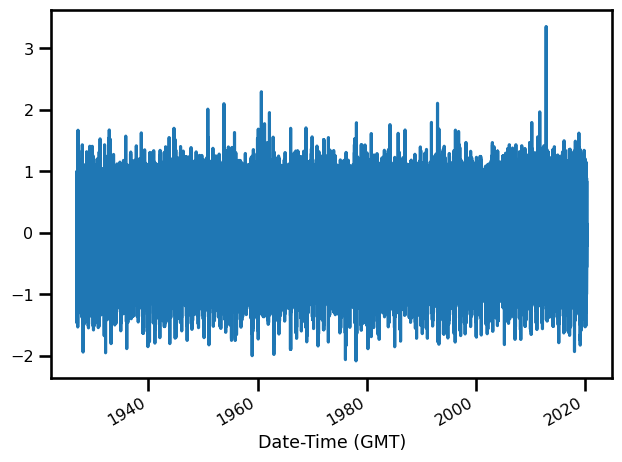

In [4]:
fig, ax = plt.subplots()

data.plot(ax=ax)

plt.tight_layout()
plt.show()

## Extremes

In [5]:
extremes_method = "BM"
block_size = "365.2425D"
extremes_type = "high"
extremes = get_extremes(
    data, 
    method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

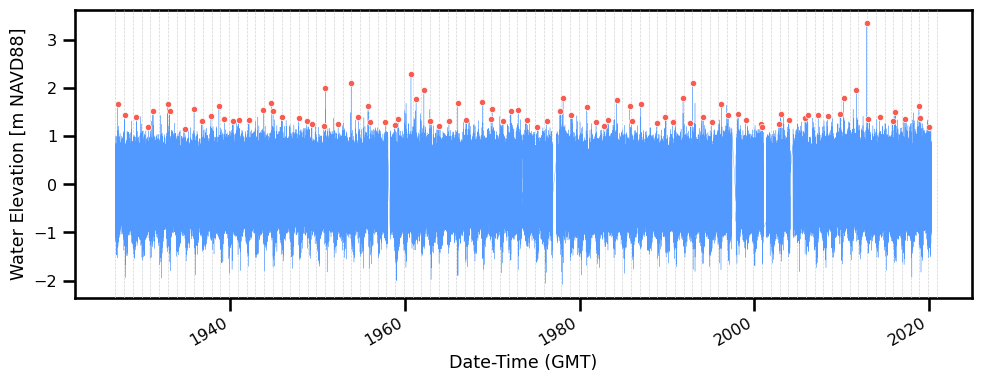

In [6]:
fig, ax = plt.subplots(figsize=(10,4))

plot_extremes(
    ax=ax,
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

plt.tight_layout()
plt.show()

## Model

We factoized the **Joint Distribution** as so:

$$
p(y,\boldsymbol{\theta}) = p(\boldsymbol{\theta})\prod_{n=1}^N p(y_n|\boldsymbol{\theta})
$$

### Prior & Likelihood

We do a uniform prior for the parameters.

$$
p(\boldsymbol{\theta}) = U(-\infty, \infty)
$$

We use the GEVD for the likelihood.

$$
p(y) \sim \text{GEVD}(\boldsymbol{\theta})
$$

where $\boldsymbol{\theta}=\{\mu,\sigma,\xi\}$ are the location, scale and shape parameters.

In [26]:


def model(y: Float[Array, "N"]=None):
    # prior parameters
    loc = numpyro.sample("loc", dist.Normal(0.0, 1.0))
    scale = numpyro.sample("scale", dist.LogNormal(0.0, 10.0))
    concentration = numpyro.sample("concentration", dist.LogNormal(0.0, 1.0))
    
    # likelihood
    numpyro.sample("obs", tfd.GeneralizedExtremeValue(loc, scale, concentration), obs=y)

In [27]:
rng_key = jrandom.PRNGKey(123)

### Variational Distribution

In [101]:
from numpyro.infer.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal

guide = AutoMultivariateNormal(model)

### Inference

$$
\boldsymbol{\phi}^* = 
\underset{\boldsymbol{\phi}}{\text{argmin}}
\hspace{2mm}
\text{ELBO}_{q}
\left[q(\boldsymbol{\theta};\boldsymbol{\phi}), p(y,\boldsymbol{\theta})\right]
$$

In [102]:
from numpyro.infer import Predictive, SVI, Trace_ELBO
optimizer = numpyro.optim.Adam(step_size=0.005)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [103]:
num_steps = 3_000
y = extremes.values
rng_key_train, rng_key = jrandom.split(rng_key, num=2)

svi_result = svi.run(rng_key=rng_key_train, num_steps=num_steps, y=y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1742.54it/s, init loss: 299.6826, avg. loss [2851-3000]: -4.2918]


### Training

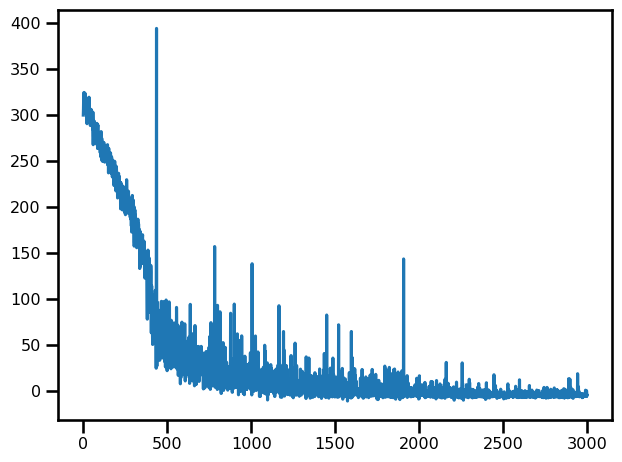

In [104]:
fig, ax = plt.subplots()
ax.plot(svi_result.losses)
plt.tight_layout()
plt.show()

### Params

In [105]:
svi_result.params

{'auto_loc': Array([ 1.3635207, -1.8698213, -1.4520376], dtype=float32),
 'auto_scale_tril': Array([[ 0.02849675,  0.        ,  0.        ],
        [ 0.03473606,  0.09428482,  0.        ],
        [-0.10685318,  0.10271374,  0.25009575]], dtype=float32)}

We notice that these variable names are not the same as the names we prescribed. 
This is because these are the parameters of the variational distribution, **not** the model.
So we need to do some extra to be able to get the proper parameters.

We can use the `Predictive` inference helper from the `numpyro` library.
In this case, we only need 1 sample because we have a simple guide.

In [106]:
params = svi_result.params
# samples = guide.get_posterior(params)
predictive = Predictive(guide, params=params, num_samples=1000)
posterior_samples = predictive(jrandom.PRNGKey(0), return_sites=["concentration"])
# posterior_samples

Now, we can extract the true parameters.

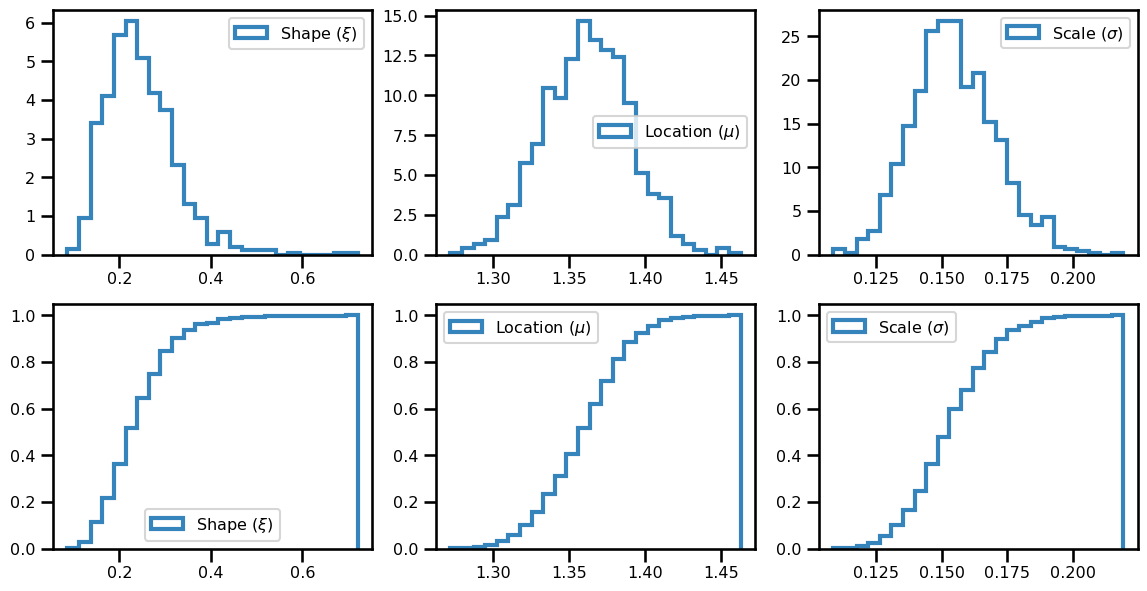

In [107]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14,7))


ax[0,0].hist(posterior_samples["concentration"], 
           bins=25, rwidth=2, alpha=0.9, 
           cumulative=False, density=True, 
           color="tab:blue", linewidth=3, histtype="step", label=r"Shape ($\xi$)",
           
)
ax[0,1].hist(posterior_samples["loc"], 
           bins=25, rwidth=2, alpha=0.9, 
           cumulative=False, density=True, 
           color="tab:blue", linewidth=3, histtype="step", label=r"Location ($\mu$)"
)
ax[0,2].hist(posterior_samples["scale"],
           bins=25, rwidth=2, alpha=0.9, 
           cumulative=False, density=True, 
           color="tab:blue", linewidth=3, histtype="step", label=r"Scale ($\sigma$)"
)

ax[1,0].hist(posterior_samples["concentration"], 
           bins=25, rwidth=2, alpha=0.9, 
           cumulative=True, density=True, 
           color="tab:blue", linewidth=3, histtype="step", label=r"Shape ($\xi$)",
           
)
ax[1,1].hist(posterior_samples["loc"], 
           bins=25, rwidth=2, alpha=0.9, 
           cumulative=True, density=True, 
           color="tab:blue", linewidth=3, histtype="step", label=r"Location ($\mu$)"
)
ax[1,2].hist(posterior_samples["scale"],
           bins=25, rwidth=2, alpha=0.9, 
           cumulative=True, density=True, 
           color="tab:blue", linewidth=3, histtype="step", label=r"Scale ($\sigma$)"
)


ax[0,0].legend()
ax[0,1].legend()
ax[0,2].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[1,2].legend()
plt.show()

In [108]:
print("Parameters (MLE):")
print(f"Shape - ξ: {np.mean(posterior_samples['concentration']):.4f}")
print(f"Loc   - μ: {np.mean(posterior_samples['loc']):.4f}")
print(f"Scale - σ: {np.mean(posterior_samples['scale']):.4f}")

Parameters (MLE):
Shape - ξ: 0.2463
Loc   - μ: 1.3619
Scale - σ: 0.1548


## Return Period

In [109]:
import numpy as np
from scipy.stats import genextreme
from jax.debug import print as jprint

return_periods = np.logspace(-1, 3,50)

def calculate_return_levels(params):
    model = tfd.GeneralizedExtremeValue(
        loc=params["loc"], 
        scale=params["scale"], 
        concentration=params["concentration"]
    )
    return model.quantile(1-1/return_periods)

In [110]:
out = jax.vmap(calculate_return_levels)(posterior_samples)

In [111]:
ciu, mu, cil = np.quantile(out, q=[0.025, 0.5, 0.975], axis=0)

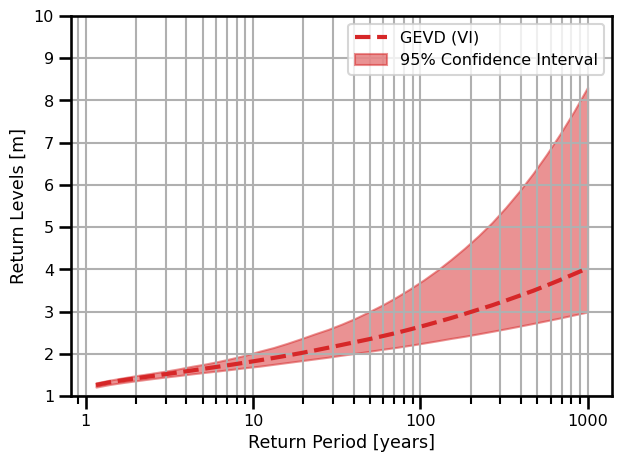

In [112]:
fig, ax = plt.subplots()

ax.plot(
    return_periods, mu, 
    linestyle="--", linewidth=3, color="tab:red",
    label="GEVD (VI)",
)

ax.fill_between(
    return_periods, 
    cil, ciu,
    alpha=0.5,
    color="tab:red",
    label="95% Confidence Interval",
)

ax.set(
    xlabel="Return Period [years]",
    ylabel="Return Levels [m]",
    xscale="log",
    ylim=[1, 10]
)
# format log scale labels
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

plt.grid(which="both", visible=True)
plt.legend()
plt.tight_layout()
plt.show()